## Workboard
Each Objective contains 1 or more KR (and Objective progress is the average of constituent KR progress). Also, KR_COUNTING_TYPE has different ways of counting Key Results (eg: Increase revenue would be counting up, Decrease downtime would be counting down, etc.

In [1]:
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
df = pd.read_csv('workboard.csv')

In [2]:
#get some insight
df.head()
#df.info()

,OBJECTIVE_ID,OBJECTIVE_OWNER_ID,OBJECTIVE_PROGRESS,OBJECTIVE_START_DATE,OBJECTIVE_TARGET_DATE,OBJECTIVE_ALIGNS_TO_ANOTHER_OBJECTIVE,TEAM_ID,TEAM_TYPE,TEAM_OWNER_ID,KR_ID,KR_PROGRESS,KR_OWNER_ID,KR_OWNER_LEVEL,KR_COUNTING_TYPE,KR_UPDATE_FREQUENCY,KR_DATA_SOURCE,OBJECTIVE_CATEGORY,NUMBER OF OBJECTIVE COMMENTS,NUMBER OF KR COMMENTS,NUMBER OF UPDATES PROVIDED TO KR
0,1,400,48,2019-10-01,2019-12-30,Yes,50,2,200,100,95,80,4,1,Weekly,1,A,2,3,10
1,2,401,48,2019-10-01,2019-12-30,No,51,2,201,101,95,81,4,1,Weekly,11,C,6,0,7
2,3,402,0,2020-07-01,2020-09-30,No,52,2,202,102,0,82,4,1,Weekly,1,B,1,4,10
3,4,403,81,2020-04-01,2020-06-30,Yes,53,1,203,103,67,83,2,1,Weekly,1,E,0,5,10
4,5,404,83,2020-01-01,2020-03-31,Yes,54,1,204,104,75,84,2,1,Weekly,1,D,5,9,10


In [3]:
# check id columns
id_columns = ['OBJECTIVE_ID','OBJECTIVE_OWNER_ID','TEAM_ID','TEAM_OWNER_ID','KR_ID','KR_OWNER_ID']
for i in id_columns:
    print(i,df[i].nunique())

OBJECTIVE_ID 1991
OBJECTIVE_OWNER_ID 1991
TEAM_ID 1991
TEAM_OWNER_ID 1991
KR_ID 1991
KR_OWNER_ID 1991


In [4]:
# Categorical columns to code
categorical_columns = ['OBJECTIVE_ALIGNS_TO_ANOTHER_OBJECTIVE','KR_UPDATE_FREQUENCY','OBJECTIVE_CATEGORY']
for i in categorical_columns:
    df[i] = df[i].astype('category')
    cat_col_name = i + '_CAT'
    df[cat_col_name] = df[i].cat.codes
    print(cat_col_name,'has been created')

OBJECTIVE_ALIGNS_TO_ANOTHER_OBJECTIVE_CAT has been created
KR_UPDATE_FREQUENCY_CAT has been created
OBJECTIVE_CATEGORY_CAT has been created


In [5]:
# Extract three new features
df['PROCESS_TIME_DAYS'] = pd.to_datetime(df['OBJECTIVE_TARGET_DATE']) - pd.to_datetime(df['OBJECTIVE_START_DATE'])
df['PROCESS_TIME_DAYS'] = df['PROCESS_TIME_DAYS'] / np.timedelta64(1, 'D')
df['OBJETIVE_START_MONTH'] = pd.DatetimeIndex(df['OBJECTIVE_START_DATE']).month
df['OBJETIVE_TARGET_MONTH'] = pd.DatetimeIndex(df['OBJECTIVE_TARGET_DATE']).month

In [6]:
analytic_columns = ['OBJECTIVE_PROGRESS','TEAM_TYPE','KR_PROGRESS','KR_OWNER_LEVEL','KR_COUNTING_TYPE','KR_DATA_SOURCE',
                    'NUMBER OF OBJECTIVE COMMENTS','NUMBER OF KR COMMENTS','NUMBER OF UPDATES PROVIDED TO KR',
                    'OBJECTIVE_ALIGNS_TO_ANOTHER_OBJECTIVE_CAT','KR_UPDATE_FREQUENCY_CAT','OBJECTIVE_CATEGORY_CAT',
                    'PROCESS_TIME_DAYS','OBJETIVE_START_MONTH','OBJETIVE_TARGET_MONTH']
df_analytic = df[analytic_columns].copy()

array([[<AxesSubplot:title={'center':'OBJECTIVE_PROGRESS'}>,
        <AxesSubplot:title={'center':'TEAM_TYPE'}>,
        <AxesSubplot:title={'center':'KR_PROGRESS'}>,
        <AxesSubplot:title={'center':'KR_OWNER_LEVEL'}>],
       [<AxesSubplot:title={'center':'KR_COUNTING_TYPE'}>,
        <AxesSubplot:title={'center':'KR_DATA_SOURCE'}>,
        <AxesSubplot:title={'center':'NUMBER OF OBJECTIVE COMMENTS'}>,
        <AxesSubplot:title={'center':'NUMBER OF KR COMMENTS'}>],
       [<AxesSubplot:title={'center':'NUMBER OF UPDATES PROVIDED TO KR'}>,
        <AxesSubplot:title={'center':'OBJECTIVE_ALIGNS_TO_ANOTHER_OBJECTIVE_CAT'}>,
        <AxesSubplot:title={'center':'KR_UPDATE_FREQUENCY_CAT'}>,
        <AxesSubplot:title={'center':'OBJECTIVE_CATEGORY_CAT'}>],
       [<AxesSubplot:title={'center':'PROCESS_TIME_DAYS'}>,
        <AxesSubplot:title={'center':'OBJETIVE_START_MONTH'}>,
        <AxesSubplot:title={'center':'OBJETIVE_TARGET_MONTH'}>,
        <AxesSubplot:>]], dtype=object)

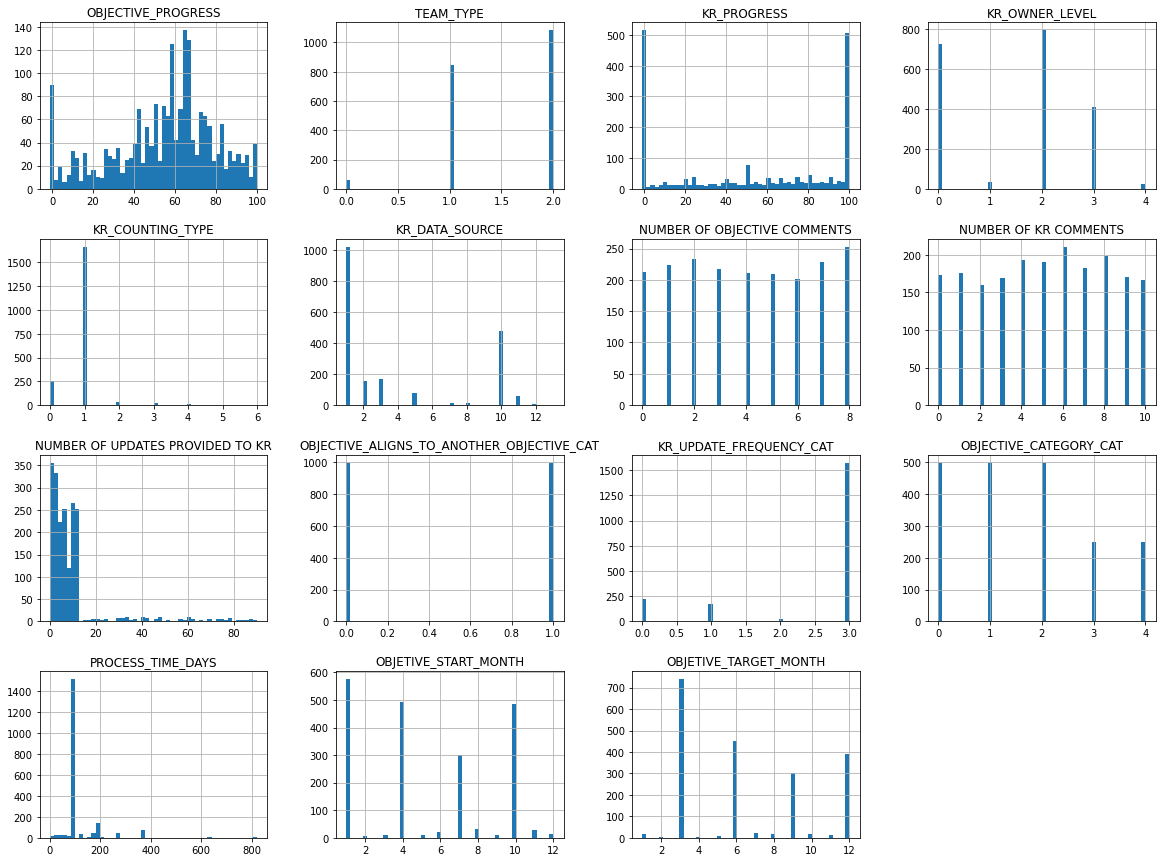

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
df_analytic.hist(bins=50,figsize=(20,15))

<AxesSubplot:>

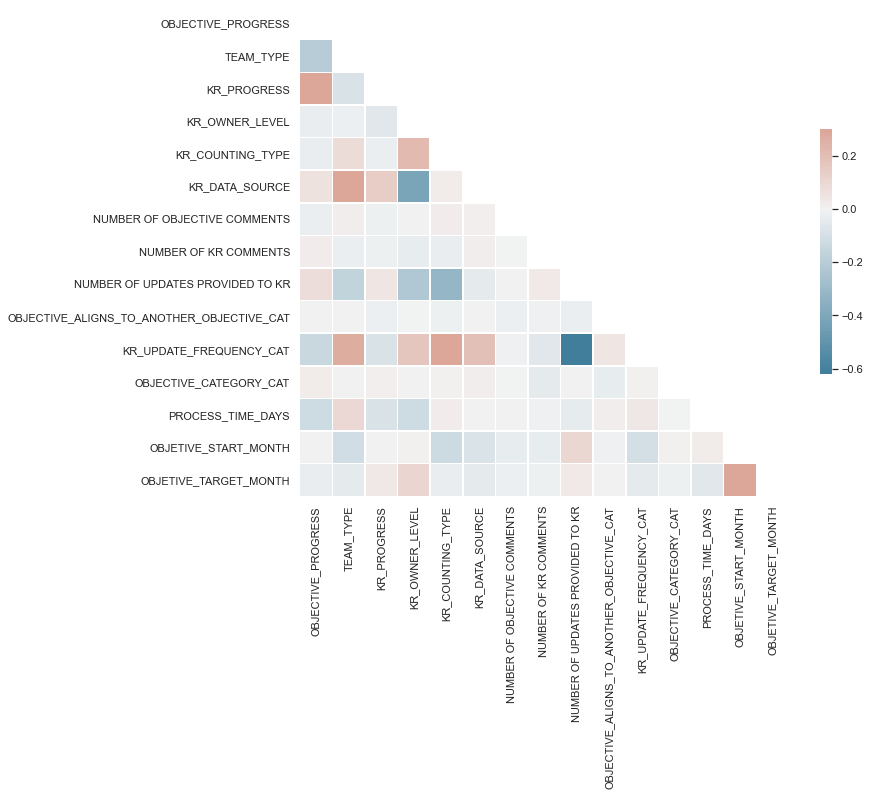

In [10]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#method{‘pearson’, ‘kendall’, ‘spearman’}
sns.set_theme(style="white")
corr = df_analytic.corr(method = 'pearson')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [13]:
input_columns = ['OBJECTIVE_PROGRESS','TEAM_TYPE','KR_OWNER_LEVEL','KR_COUNTING_TYPE','KR_DATA_SOURCE',
                 'NUMBER OF OBJECTIVE COMMENTS','NUMBER OF KR COMMENTS','NUMBER OF UPDATES PROVIDED TO KR',
                 'OBJECTIVE_ALIGNS_TO_ANOTHER_OBJECTIVE_CAT','KR_UPDATE_FREQUENCY_CAT','OBJECTIVE_CATEGORY_CAT',
                 'PROCESS_TIME_DAYS','OBJETIVE_START_MONTH','OBJETIVE_TARGET_MONTH','KR_PROGRESS']

Using variance inflation factor (VIF)

In [14]:
# the independent variables set
X = df_analytic[input_columns]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                                      feature       VIF
0                          OBJECTIVE_PROGRESS  8.023942
1                                   TEAM_TYPE  9.876897
2                              KR_OWNER_LEVEL  3.590571
3                            KR_COUNTING_TYPE  4.709255
4                              KR_DATA_SOURCE  3.377749
5                NUMBER OF OBJECTIVE COMMENTS  3.201131
6                       NUMBER OF KR COMMENTS  3.409477
7            NUMBER OF UPDATES PROVIDED TO KR  1.945663
8   OBJECTIVE_ALIGNS_TO_ANOTHER_OBJECTIVE_CAT  1.971603
9                     KR_UPDATE_FREQUENCY_CAT  9.803267
10                     OBJECTIVE_CATEGORY_CAT  2.452902
11                          PROCESS_TIME_DAYS  2.956278
12                       OBJETIVE_START_MONTH  5.492231
13                      OBJETIVE_TARGET_MONTH  7.550150
14                                KR_PROGRESS  4.150197


## Clustering 

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering

In [16]:
xx = [0]
yy = [0]
for k in range(2,15):
    X = StandardScaler().fit_transform(df_analytic)
    #Set number of clusters at initialisation time
    k_means = KMeans(n_clusters=k)
    #Run the clustering algorithm
    model = k_means.fit(X)
    model
    #Generate cluster predictions and store in y_hat
    y_hat = k_means.predict(X)
    xx.append(k)
    yy.append(k_means.inertia_)

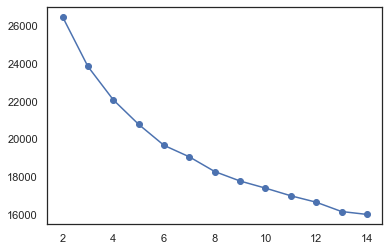

In [17]:
plt.scatter(xx[1:], yy[1:])
plt.plot(xx[1:], yy[1:])
plt.show()

In [18]:
X = StandardScaler().fit_transform(df_analytic)
#Set number of clusters at initialisation time
k_means = KMeans(n_clusters=4)
#Run the clustering algorithm
model = k_means.fit(X)
model
#Generate cluster predictions and store in y_hat
y_hat = k_means.predict(X)
unique, counts = np.unique(y_hat, return_counts=True)
dict(zip(unique, counts))

{0: 565, 1: 202, 2: 707, 3: 517}

In [19]:
df_analytic['cluster'] = y_hat.tolist()

In [20]:
# take back IDs
df_analytic['OBJECTIVE_ID'] = df['OBJECTIVE_ID']
df_analytic['OBJECTIVE_OWNER_ID'] = df['OBJECTIVE_OWNER_ID']
df_analytic['TEAM_ID'] = df['TEAM_ID']
df_analytic['TEAM_OWNER_ID'] = df['TEAM_OWNER_ID']
df_analytic['KR_ID'] = df['KR_ID']
df_analytic['KR_OWNER_ID'] = df['KR_OWNER_ID']

In [21]:
df_analytic

,OBJECTIVE_PROGRESS,TEAM_TYPE,KR_PROGRESS,KR_OWNER_LEVEL,KR_COUNTING_TYPE,KR_DATA_SOURCE,NUMBER OF OBJECTIVE COMMENTS,NUMBER OF KR COMMENTS,NUMBER OF UPDATES PROVIDED TO KR,OBJECTIVE_ALIGNS_TO_ANOTHER_OBJECTIVE_CAT,...,PROCESS_TIME_DAYS,OBJETIVE_START_MONTH,OBJETIVE_TARGET_MONTH,cluster,OBJECTIVE_ID,OBJECTIVE_OWNER_ID,TEAM_ID,TEAM_OWNER_ID,KR_ID,KR_OWNER_ID
0,48,2,95,4,1,1,2,3,10,1,...,90.0,10,12,2,1,400,50,200,100,80
1,48,2,95,4,1,11,6,0,7,0,...,90.0,10,12,3,2,401,51,201,101,81
2,0,2,0,4,1,1,1,4,10,0,...,91.0,7,9,0,3,402,52,202,102,82
3,81,1,67,2,1,1,0,5,10,1,...,90.0,4,6,2,4,403,53,203,103,83
4,83,1,75,2,1,1,5,9,10,1,...,90.0,1,3,2,5,404,54,204,104,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986,73,2,100,0,1,10,7,5,4,1,...,89.0,1,3,3,1994,2386,2043,2193,2093,2073
1987,65,2,69,0,1,10,1,0,9,0,...,273.0,7,3,3,1996,2387,2045,2195,2095,2075
1988,100,2,100,0,1,10,4,3,10,0,...,89.0,1,3,3,1998,2388,2047,2197,2097,2077
1989,100,2,100,0,1,10,2,8,3,1,...,89.0,1,3,3,1999,2389,2048,2198,2098,2078


In [22]:
df_analytic.to_csv('workboard_result.csv')